# LDA (Latent Dirichlet Allocation)

Here, LDA is employed on 18 topics based on the coherence graph obtained earlier. The KL Divergence Heatmap and Document Topic Matrix is visualised and the quality of the topics is evaluated. Aditionally, a Logistic Regression Model is employed to evaluate the Topic Modelling Technique further.

In [1]:
import pandas as pd
import os
os.chdir('D:/Down') #Replace the location to where the output.csv file is stored.
df = pd.read_csv('output.csv')


In [4]:
pip install nltk #Install necessary libraries

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [6]:
import gensim
import nltk
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
import spacy
nltk.download('stopwords')
nlp=spacy.load('en_core_web_sm',disable=['parser', 'ner'])

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sahre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The word cloud is visualised to check the frequently occurring words and decide on the preprocessing techniques.

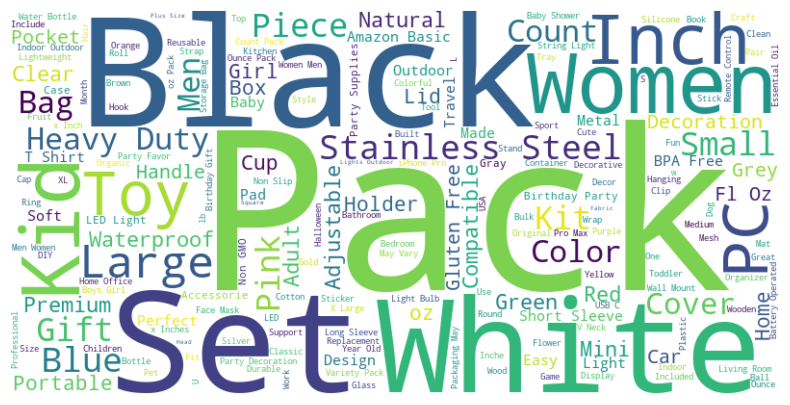

In [4]:
import pandas as pd #A wordcloud is visualised showcasing the most frequent words in the ARMBench Dataset
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = ' '.join(df['Container'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Before employing LDA, the captions are preprocessed. This includes tokenisation, stemming, stopword removal, bigram modelling, and lemmatization. This is carried out using NLTK (Natural Language ToolKit)

In [6]:
subdf = df.head(50000) #50000 annotations corresponding to the 50000 images used are taken

In [10]:
from nltk.tokenize import word_tokenize #tokenisation

def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text.lower())
    elif isinstance(text, list):
        return [word_tokenize(str(item).lower()) for item in text]
    else:
        return []

In [11]:
import pandas as pd #stemming
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

def stem_text(tokens):
    if isinstance(tokens, str):  
        return stemmer.stem(tokens)
    elif isinstance(tokens, list): 
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
        return stemmed_tokens
    else:
        return []


In [12]:
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

custom_stopwords = ["pack", "oz", "set", "may", "vary"] #Custom stopwords are added based on the wordcloud analysis

# Extend the original list
stop_words.update(custom_stopwords)

def remove_stopwords(tokens):
    if isinstance(tokens, str): 
        if tokens not in stop_words:
            return [tokens]
        else:
            return []
    elif isinstance(tokens, list): 
        filtered_tokens = [token for token in tokens if token not in stop_words]
        return filtered_tokens
    else:
        return []

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sahre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
subdf['Tokens'] = subdf['Container'].apply(tokenize_text)
subdf['Tokens'] = subdf['Tokens'].apply(stem_text)
subdf['Tokens'] = subdf['Tokens'].apply(remove_stopwords)

C:\Users\sahre\AppData\Local\Temp\ipykernel_14012\4225146729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['Tokens'] = subdf['Container'].apply(tokenize_text)
C:\Users\sahre\AppData\Local\Temp\ipykernel_14012\4225146729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['Tokens'] = subdf['Tokens'].apply(stem_text)
C:\Users\sahre\AppData\Local\Temp\ipykernel_14012\4225146729.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [14]:
bigram = gensim.models.Phrases(subdf["Tokens"], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [15]:
#bigram modelling
def create_bigrams(texts):

    return [bigram_mod[doc] for doc in texts]

In [16]:

data_bigrams = create_bigrams(subdf["Tokens"])

In [17]:
import spacy
from tqdm import tqdm  
#lemmatizing
nlp = spacy.load('en_core_web_sm')

def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    texts_op = []

    with tqdm(total=len(texts), desc="Lemmatizing", unit="text") as progress_bar:
        for sent in texts:
            doc = nlp(" ".join(sent))
            texts_op.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

            progress_bar.update(1)

    return texts_op


In [18]:
data_lemmatized = lemmatize(data_bigrams, allowed_postags=[ 'NOUN', 'ADJ', 'VERB'])

Lemmatizing: 100%|█████████████████████████████████████████████████████████████| 50000/50000 [31:56<00:00, 26.09text/s]


The Dictionary and corpus is defined and the LDA model is built with 18 topics.

In [19]:
from gensim import corpora
import gensim
from gensim.models import CoherenceModel
from tqdm import tqdm 

gensim_dictionary = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized   
gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]




In [20]:
# LDA Model
lda_model = gensim.models.ldamodel.LdaModel( #the lda model is defined
    corpus=gensim_corpus,
    id2word=gensim_dictionary,
    num_topics=18,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)


In [21]:

with tqdm(total=lda_model.passes, desc="LDA Model Training", unit="pass") as progress_bar:
    for i in range(lda_model.passes):
        lda_model.update(gensim_corpus)
        progress_bar.update(1)


coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=data_lemmatized,
    dictionary=gensim_dictionary,
    coherence='c_v'
)


with tqdm(total=1, desc="Calculating Coherence Score", unit="score") as progress_bar:
    coherence_lda = coherence_model_lda.get_coherence()
    progress_bar.update(1)




Calculating Coherence Score: 100%|████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.82s/score]


The KL Divergence Heatmap is visualised for the 18 topics to evaluate the distinction between the distributions.

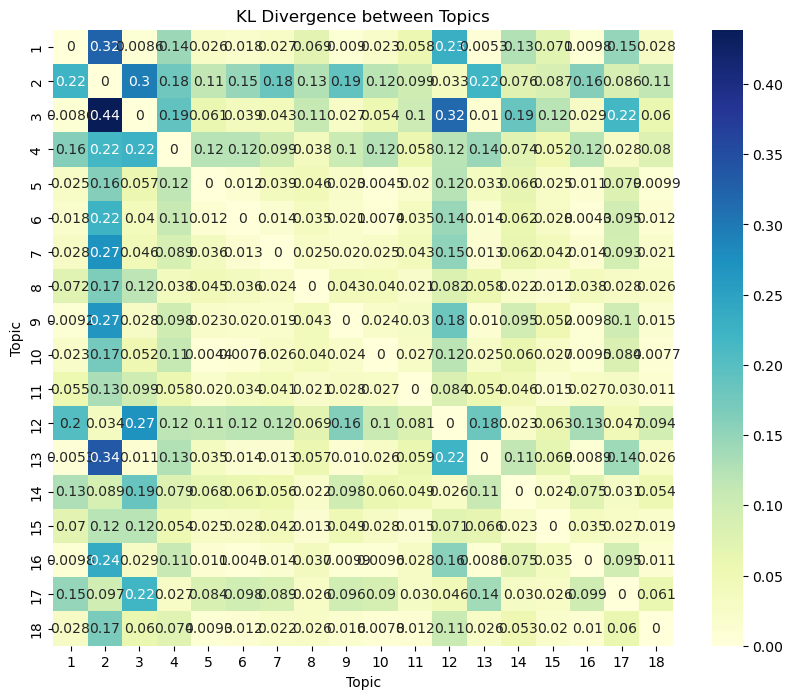

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
num_topics = 18

EPSILON = 1e-10

def kl_divergence(p, q): #Kl divergence is computed and plotted
    p = np.array(p) + EPSILON
    q = np.array(q) + EPSILON
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))


kl_div_matrix = np.zeros((num_topics, num_topics))
for i in range(num_topics):
    for j in range(num_topics):
        topic_p = [prob for _, prob in lda_model.get_topic_terms(i)]
        topic_q = [prob for _, prob in lda_model.get_topic_terms(j)]
        kl_div_matrix[i, j] = kl_divergence(topic_p, topic_q)



plt.figure(figsize=(10, 8))
sns.heatmap(kl_div_matrix, annot=True, cmap="YlGnBu", xticklabels=range(1, num_topics+1), yticklabels=range(1, num_topics+1))
plt.title("KL Divergence between Topics")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()




Here, the Document-Topic Distribution is visualised.

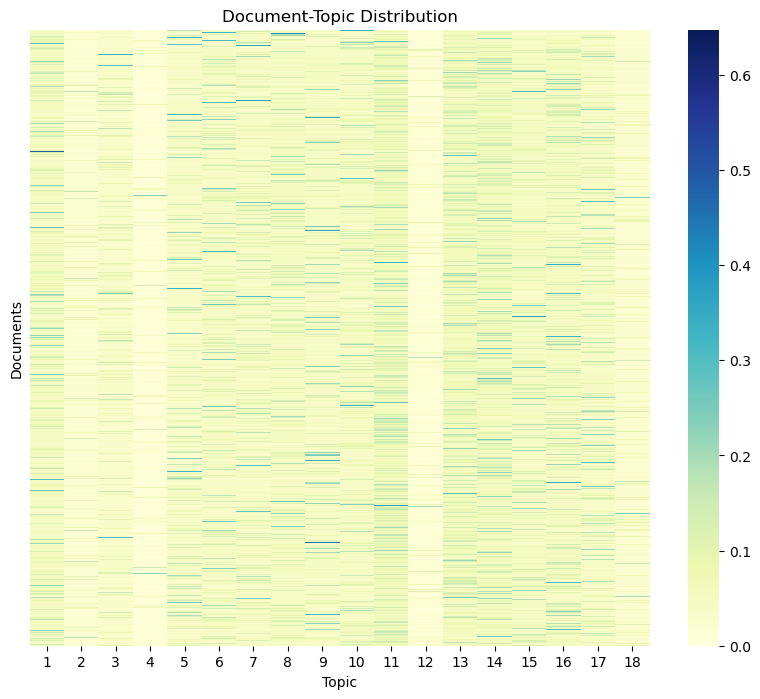

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

doc_topic_matrix = np.zeros((len(gensim_corpus), lda_model.num_topics))
for doc_id, doc in enumerate(gensim_corpus):
    topic_dist = lda_model.get_document_topics(doc)
    for topic, prob in topic_dist:
        doc_topic_matrix[doc_id][topic] = prob

plt.figure(figsize=(10, 8))
sns.heatmap(doc_topic_matrix, cmap="YlGnBu", xticklabels=range(1, lda_model.num_topics+1), yticklabels=False)  # Set yticklabels to False
plt.title("Document-Topic Distribution")
plt.xlabel("Topic")
plt.ylabel("Documents")
plt.show()



The Dominant Topics are added to a new column in the Dataframe called Dominant Topic. A Logistic Regression Model is used to further evaluate the Topic Modelling Technique. A manual analysis is also carried out by visualising the word clouds for different topics.

In [30]:

dominant_topics = []

for tokens in subdf['Tokens']:
    doc_bow = lda_model.id2word.doc2bow(tokens)
    doc_topics = lda_model.get_document_topics(doc_bow)
    dominant_topic = max(doc_topics, key=lambda item: item[1])[0]
    dominant_topics.append(dominant_topic)

subdf['Dominant_Topic'] = dominant_topics



C:\Users\sahre\AppData\Local\Temp\ipykernel_15548\1958850564.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['Dominant_Topic'] = dominant_topics


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


subdf = subdf.dropna(subset=['Container'])

train_df, test_df = train_test_split(subdf, test_size=0.2, random_state=42)


vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['Container'])
X_test = vectorizer.transform(test_df['Container'])
#to further evaluate the quality of topics against other clustering approaches, a logistic regression model is employed

logreg_model = LogisticRegression(max_iter=1000, random_state=42)


logreg_model.fit(X_train, train_df['Dominant_Topic'])


preds = logreg_model.predict(X_test)


accuracy = accuracy_score(test_df['Dominant_Topic'], preds)
precision = precision_score(test_df['Dominant_Topic'], preds, average='weighted')
recall = recall_score(test_df['Dominant_Topic'], preds, average='weighted')
f1 = f1_score(test_df['Dominant_Topic'], preds, average='weighted')


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

print(classification_report(test_df['Dominant_Topic'], preds))


num_classes = len(test_df['Dominant_Topic'].unique())
average_precision = precision_score(test_df['Dominant_Topic'], preds, average='macro')
average_recall = recall_score(test_df['Dominant_Topic'], preds, average='macro')
average_f1 = f1_score(test_df['Dominant_Topic'], preds, average='macro')

# Print average metrics
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1-Score:", average_f1)


Accuracy: 0.7974
Precision: 0.7964339908383942
Recall: 0.7974
F1-Score: 0.7957549164895239
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       272
           1       0.66      0.59      0.63       363
           2       0.76      0.70      0.73       251
           3       0.77      0.68      0.73       218
           4       0.78      0.71      0.74       180
           5       0.78      0.69      0.73       234
           6       0.80      0.84      0.82       649
           7       0.81      0.82      0.81       476
           9       0.84      0.80      0.82       358
          10       0.86      0.84      0.85       341
          11       0.78      0.73      0.75       267
          12       0.86      0.88      0.87      1354
          13       0.80      0.88      0.84      1825
          14       0.83      0.66      0.74       336
          15       0.82      0.85      0.83      1089
          16       0.85      0.83      0.84 

C:\Users\sahre\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



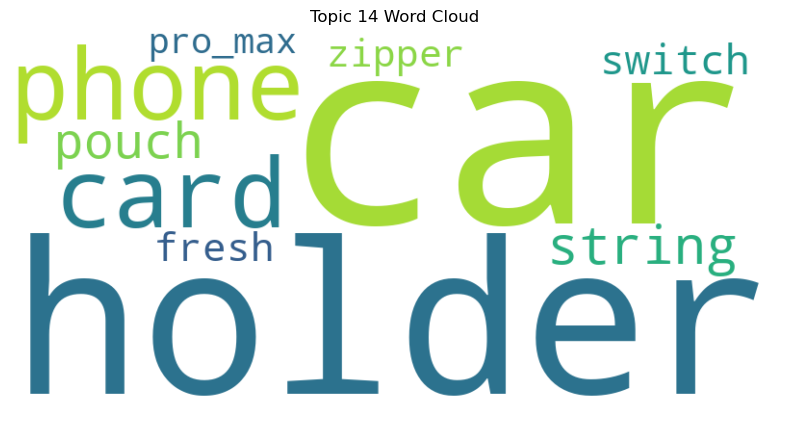

C:\Users\sahre\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



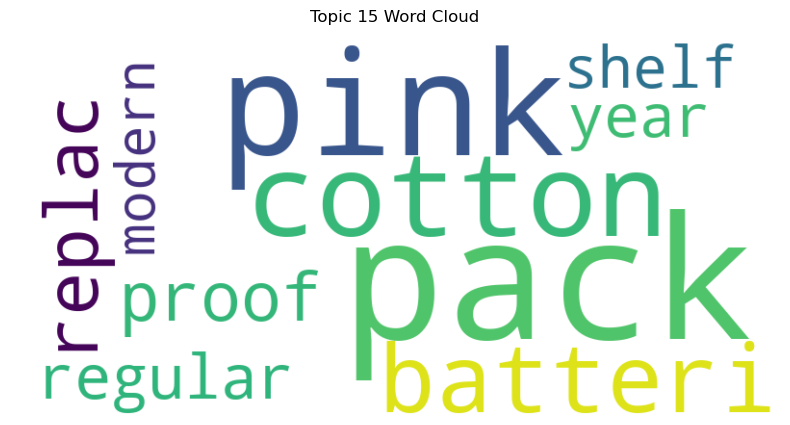

C:\Users\sahre\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



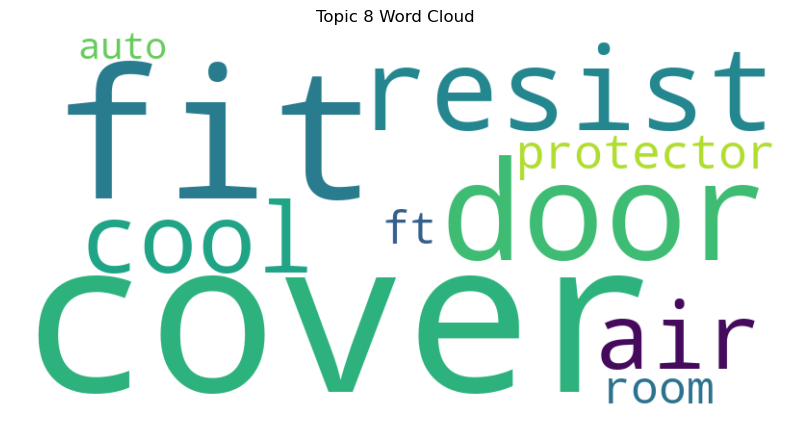

C:\Users\sahre\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



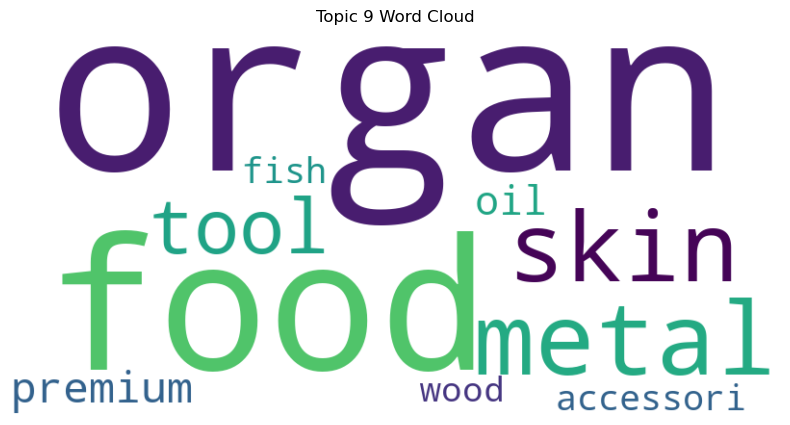

C:\Users\sahre\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



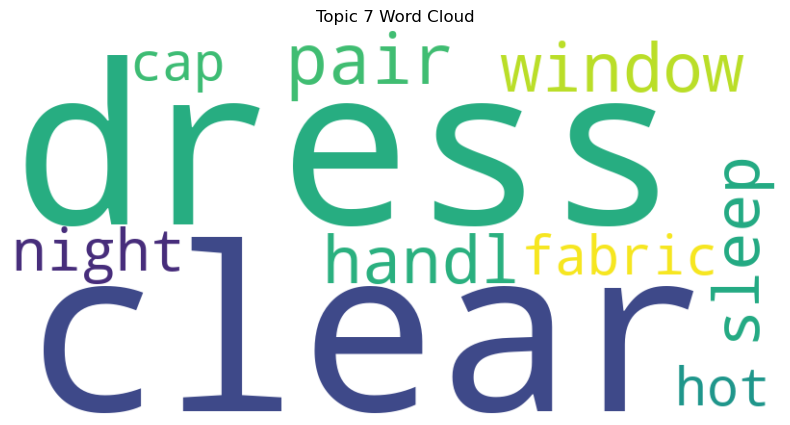

C:\Users\sahre\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



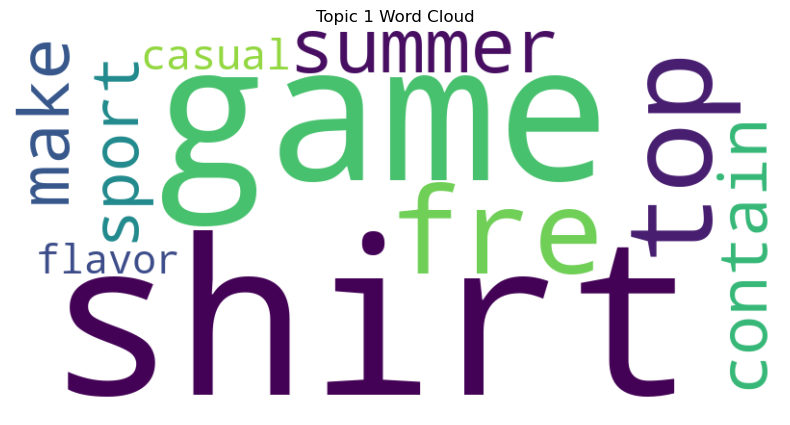

C:\Users\sahre\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



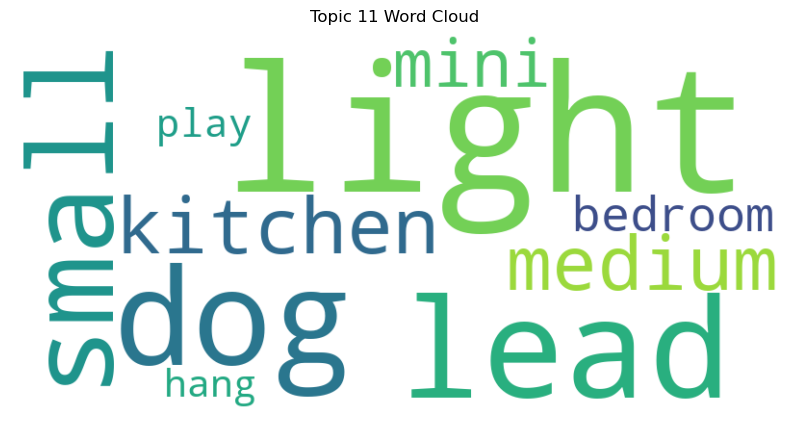

C:\Users\sahre\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



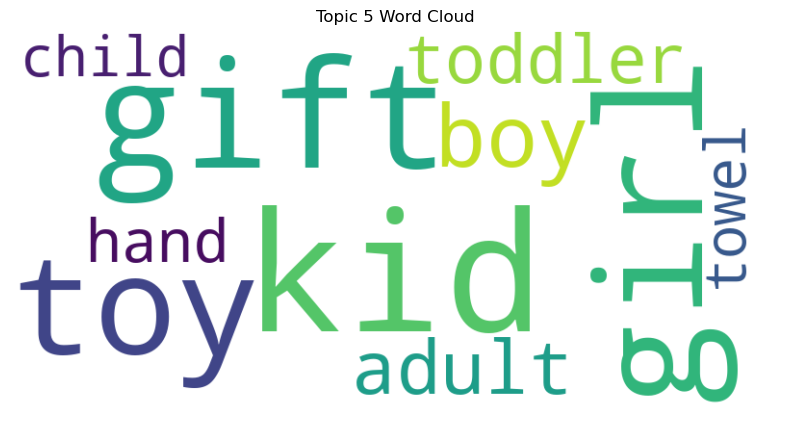

C:\Users\sahre\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



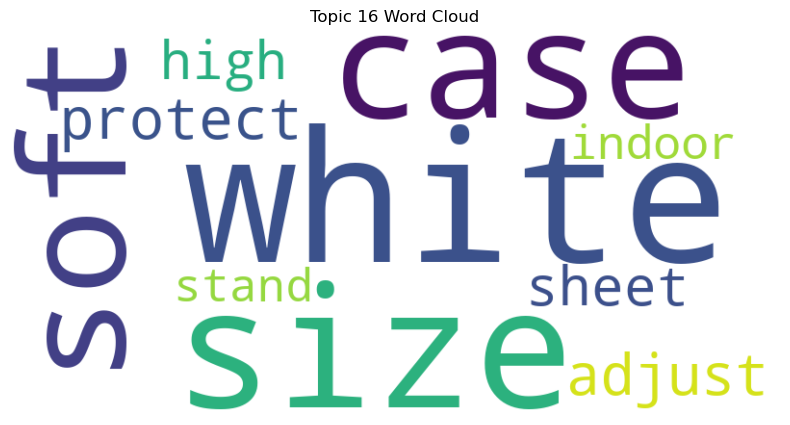

C:\Users\sahre\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



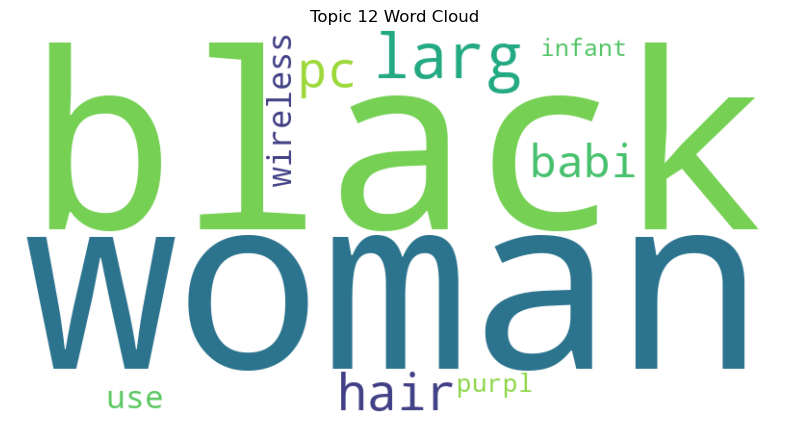

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#word clouds of every topic 


topic_words = lda_model.show_topics(formatted=False, num_words=10)


for topic_id, words in topic_words:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_id + 1} Word Cloud")
    plt.axis('off')
    plt.show()
